# Conditional Neural Processes (CNP) for 1D regression.
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import datetime
import numpy as np
import torchsnooper
import plotting_utils_cnp as plotting
import data_generator as data
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import dask.dataframe as dd
import sys
sys.path.append('../utilities')
import utilities as utils
import import_ipynb
import conditional_neural_process_model as cnp

In [7]:
TRAINING_ITERATIONS = int(3601) # Total number of training points: training_iterations * batch_size * max_content_points
#BATCH_SIZE = 100 # number of simulation configurations

MAX_CONTEXT_POINTS = 1000 # 2000 # 4000
MAX_TARGET_POINTS =  2000 # 4000 # 8000
CONTEXT_IS_SUBSET = True
BATCH_SIZE = 1
CONFIG_WISE = False
PLOT_AFTER = int(200)
torch.manual_seed(0)

# all available x config/ physics parameters are ["radius","thickness","npanels","theta","length","height","z_offset","volume","nC_Ge77","time_0[ms]","x_0[m]","y_0[m]","z_0[m]","px_0[m]","py_0[m]","pz_0[m]","ekin_0[eV]","edep_0[eV]","time_t[ms]","x_t[m]","y_t[m]","z_t[m]","px_t[m]","py_t[m]","pz_t[m]","ekin_t[eV]","edep_t[eV]","nsec"]
# Comment: if using data version v1.1 for training, "radius","thickness","npanels","theta","length" is probably necessary
names_x=["radius","thickness","npanels","theta","length","r_0[m]","z_0[m]","time_t[ms]","r_t[m]","z_t[m]","L_t[m]","ln(E0vsET)","edep_t[eV]","nsec"]
name_y ='total_nC_Ge77[cts]'
x_size = len(names_x)
if isinstance(name_y,str):
    y_size = 1
else:
    y_size = len(name_y)

RATIO_TESTING_VS_TRAINING = 1/40
version="n1.5"
path_to_files=f"../simulation/out/LF/{version}/tier2/"
path_out = f'./out/'
f_out = f'{path_out}CNPGauss_{version}_{TRAINING_ITERATIONS}_c{MAX_CONTEXT_POINTS}_t{MAX_TARGET_POINTS}'

In [8]:
# Set data augmentation parameters
USE_DATA_AUGMENTATION = "mixup" #"smote" #False #"mixup"
USE_BETA = [0.1,0.1] # uniform => None, beta => [a,b] U-shape [0.1,0.1] Uniform [1.,1.] falling [0.2,0.5] rising [0.2,0.5]
SIGNAL_TO_BACKGROUND_RATIO = "" # "_1to4" # used for smote augmentation

if USE_DATA_AUGMENTATION:
    path_out = f'./out/{USE_DATA_AUGMENTATION}/'
    f_out = f'CNPGauss_{version}_{TRAINING_ITERATIONS}_c{MAX_CONTEXT_POINTS}_t{MAX_TARGET_POINTS}_{USE_DATA_AUGMENTATION}{SIGNAL_TO_BACKGROUND_RATIO}'
    if USE_DATA_AUGMENTATION == "mixup":
        path_to_files = f"../simulation/out/LF/{version}/tier3/beta_{USE_BETA[0]}_{USE_BETA[1]}/"
        f_out = f'CNPGauss_{version}_{TRAINING_ITERATIONS}_c{MAX_CONTEXT_POINTS}_t{MAX_TARGET_POINTS}_beta_{USE_BETA[0]}_{USE_BETA[1]}'
    elif USE_DATA_AUGMENTATION == "smote" and CONFIG_WISE == True:
        path_to_files = f"../simulation/out/LF/{version}/tier3/smote{SIGNAL_TO_BACKGROUND_RATIO}/"



In [9]:
d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size+1
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = cnp.DeterministicModel(encoder_sizes,decoder_sizes)

model.load_state_dict(torch.load("./out/CNPGauss_v1.4_3601_c1000_t2000_beta_0.1_0.1_model.pth"))
model.eval()


DeterministicModel(
  (_encoder): DeterministicEncoder(
    (linears): ModuleList(
      (0): Linear(in_features=15, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (_decoder): DeterministicDecoder(
    (linears): ModuleList(
      (0): Linear(in_features=46, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(

../simulation/out/LF/n1.5/tier2/neutron-sim-LF-n1.5-0000-tier2.csv
0/25 2024-06-11 21:17:22, LF, radius: 169.6 cm, test loss: 113.80020904541016 (bce 0.415647029876709)
../simulation/out/LF/n1.5/tier2/neutron-sim-LF-n1.5-0001-tier2.csv
1/25 2024-06-11 21:17:24, LF, radius: 224.6 cm, test loss: 141.53033447265625 (bce 0.5475000739097595)
../simulation/out/LF/n1.5/tier2/neutron-sim-LF-n1.5-0002-tier2.csv
2/25 2024-06-11 21:17:28, LF, radius: 181.8 cm, test loss: 154.25613403320312 (bce 0.5714284181594849)
../simulation/out/LF/n1.5/tier2/neutron-sim-LF-n1.5-0003-tier2.csv
3/25 2024-06-11 21:17:31, LF, radius: 169.1 cm, test loss: 115.34493255615234 (bce 0.4214281737804413)
../simulation/out/LF/n1.5/tier2/neutron-sim-LF-n1.5-0100-tier2.csv
4/25 2024-06-11 21:17:34, LF, radius: 155.1 cm, test loss: 128.04388427734375 (bce 0.4550972580909729)
../simulation/out/LF/n1.5/tier2/neutron-sim-LF-n1.5-0101-tier2.csv
5/25 2024-06-11 21:17:36, LF, radius: 102.7 cm, test loss: 145.7127685546875 (bce 0.

/Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/conditional-neural-process/plotting_utils_cnp.py:161: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(9, 3))


../simulation/out/LF/n1.5/tier2/neutron-sim-LF-n1.5-0207-tier2.csv
21/25 2024-06-11 21:18:12, LF, radius: 199.5 cm, test loss: 149.46246337890625 (bce 0.5465376377105713)
../simulation/out/LF/n1.5/tier2/neutron-sim-LF-n1.5-0208-tier2.csv
22/25 2024-06-11 21:18:14, LF, radius: 181.2 cm, test loss: 227.0963592529297 (bce 0.7446025013923645)
../simulation/out/LF/n1.5/tier2/neutron-sim-LF-n1.5-0209-tier2.csv
23/25 2024-06-11 21:18:15, LF, radius: 108.4 cm, test loss: 156.93701171875 (bce 0.5382391214370728)
../simulation/out/LF/n1.5/tier2/neutron-sim-LF-n1.5-0210-tier2.csv
24/25 2024-06-11 21:18:17, LF, radius: 211.8 cm, test loss: 145.9278106689453 (bce 0.5445175766944885)


<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

<Figure size 900x300 with 0 Axes>

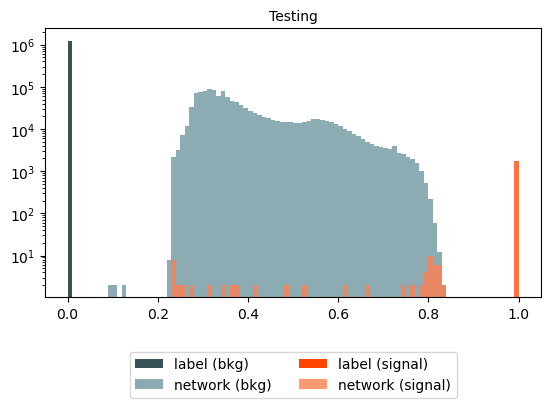

<Figure size 640x480 with 0 Axes>

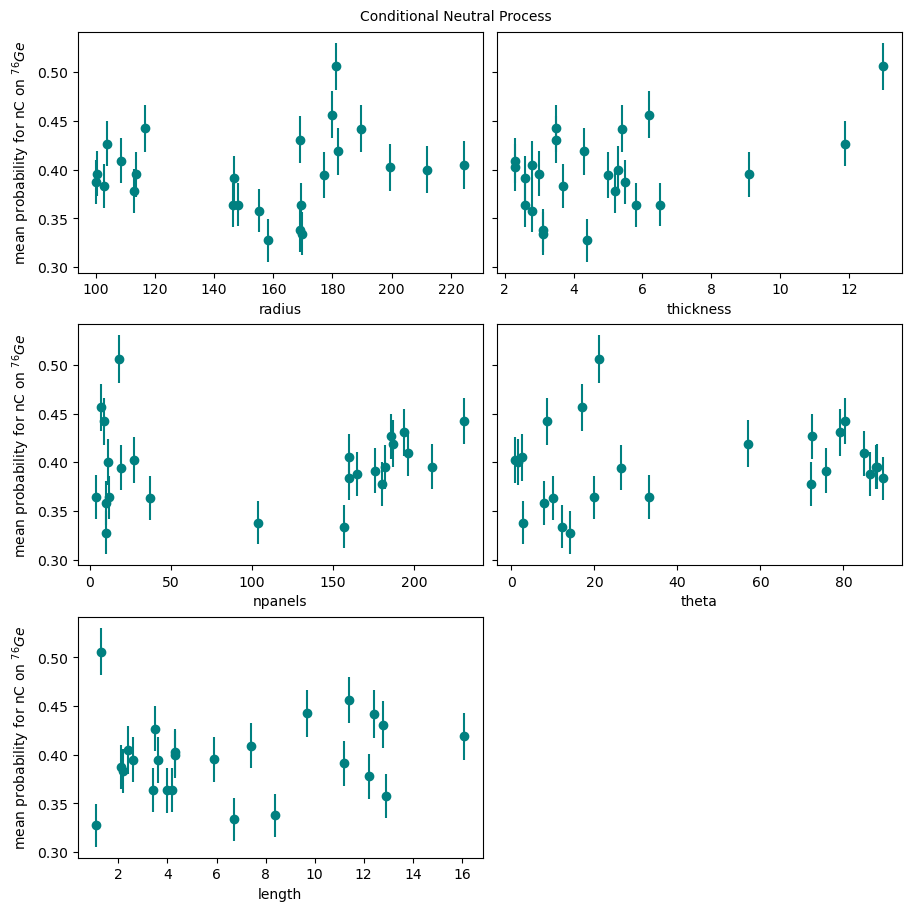

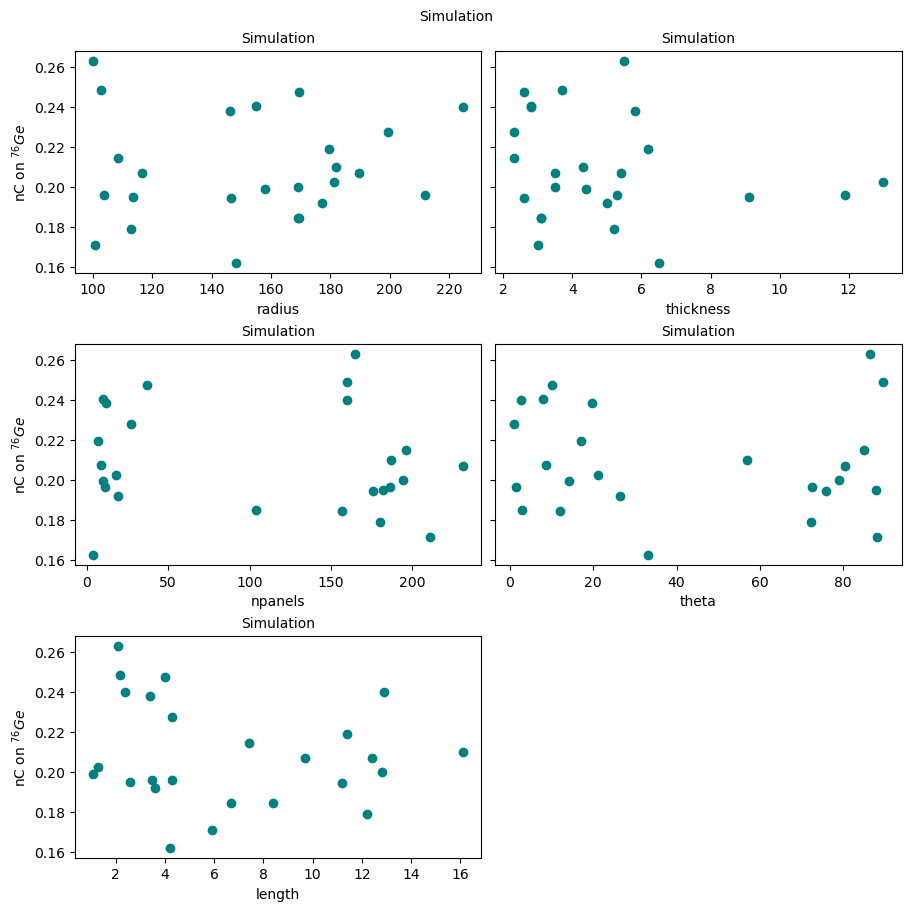

In [10]:

mode="LF"
filelist = utils.get_all_files(f"../simulation/out/{mode}/n{version[1:]}/tier2/")
num_total_points = 50000


MAX_CONTEXT_POINTS_NEW = int(1/3 * num_total_points)
MAX_TARGET_POINTS_NEW = 2 * (MAX_CONTEXT_POINTS_NEW)
bce = nn.BCELoss()

x_lf = np.empty([0,6])
sum_target_y_lf = np.empty([0,1])
mean_mu_cnp_lf = np.empty([0,1])
mean_sigma_cnp_lf = np.empty([0,1])
rGe77_lf = np.empty([0,1])
hist_target_sig = hist_target_bkg = hist_pred_sig = hist_pred_bkg = np.zeros(100)
fout = open(f'{path_out}{f_out}_training_new_samples.txt', "a")

# create a PdfPages object
pdf = PdfPages(f'{path_out}{f_out}_result_{mode}_new_samples.pdf')

for i,file in enumerate(filelist):
    print(file)
    path_to_files = file[:-4]
    dataset_config = data.DataGeneration(num_iterations=1, num_context_points=MAX_CONTEXT_POINTS_NEW, num_target_points=MAX_TARGET_POINTS_NEW, batch_size = 1, use_data_augmentation="None", path_to_files=path_to_files,x_size=x_size,y_size=y_size, mode = "config", ratio_testing=0.,names_x=names_x, name_y=name_y)
    data_config = dataset_config.get_data(0, CONTEXT_IS_SUBSET)
    # Get the predicted mean and variance at the target points for the testing set
    log_prob_config, mu_config, sigma_config = model(data_config.query, data_config.target_y)
    # Define the loss
    config_loss = -log_prob_config.mean()
    if max(mu_config[0].detach().numpy()) <= 1 and min(mu_config[0].detach().numpy()) >= 0:
            loss_bce_config = bce(mu_config,  data_config.target_y)
    else:
            loss_bce_config = -1.

    mu_config = mu_config[0].detach().numpy()
    target_y = data_config.target_y[0].detach().numpy()
    df = pd.read_csv(file, index_col=0)
    tmp = df[["fidelity","radius","thickness","npanels","theta","length"]].to_numpy()
    x_lf         = np.append(x_lf,[df[["fidelity","radius","thickness","npanels","theta","length"]].to_numpy()[0]],axis=0)

    sum_target_y_tmp = np.array([np.sum(target_y)])
    sum_target_y_lf    = np.append(sum_target_y_lf, [sum_target_y_tmp], axis=0)
    mean_mu_tmp = np.array([np.mean(mu_config)])
    mean_mu_cnp_lf = np.append(mean_mu_cnp_lf, [mean_mu_tmp], axis=0)
    mean_sigma_tmp = np.array([np.mean(sigma_config[0].detach().numpy())])
    mean_sigma_cnp_lf = np.append(mean_sigma_cnp_lf, [mean_sigma_tmp], axis=0)
    rGe77_lf = np.append(rGe77_lf,[np.array([np.sum(pd.read_csv(file)["prod_rate_Ge77[nuc/(kg*yr)]"].to_numpy())])], axis=0)
    #print(np.sum(pd.read_csv(file)["prod_rate_Ge77[nuc/(kg*yr)]"].to_numpy()))
    hist_target_sig, hist_target_bkg, hist_pred_sig, hist_pred_bkg = plotting.sum_hist(mu_config, target_y, hist_target_sig, hist_target_bkg, hist_pred_sig, hist_pred_bkg)
    print("{}/{} {}, {}, radius: {} cm, test loss: {} (bce {})".format(i,len(filelist),datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), mode,x_lf[-1,1], config_loss, loss_bce_config))
    fout.write("{}, Iteration: {}, test loss: {} (bce {})\n".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i, config_loss, loss_bce_config))
    fig = plotting.plot_result_configwise(mu_config, target_y, f'{config_loss:.2f}', x_lf[-1][1:])
    pdf.savefig(fig)
    #plt.show()
    plt.clf()

    
fig1 = plotting.plot_result_summed(hist_target_sig, hist_target_bkg, hist_pred_sig, hist_pred_bkg)
pdf.savefig(fig1)
plt.show()
plt.clf()

fig2,_ = plt.subplots(3,2,sharey=True,figsize=(9, 9),layout="constrained")
ax2 = fig2.axes
for i in range(len(x_lf[0,:])-1):

    #ax2[i].plot(x_lf[:,0],mean_mu_cnp,'o')
    ax2[i].errorbar(x_lf[:,i+1], mean_mu_cnp_lf[:,0], yerr=mean_sigma_cnp_lf[:,0],fmt='o', color='teal')
    
    ax2[i].set_xlabel(names_x[i])
    if i % 2 == 0:
        ax2[i].set_ylabel(r'mean probability for nC on $^{76}Ge$')
    #ax2[i].set_ylim(0.0,0.15)
for i in range(len(x_lf[0,:])-1,len(ax2)):
     ax2[i].set_axis_off()
fig2.suptitle('Conditional Neutral Process', fontsize=10)
pdf.savefig(fig2)
plt.show()


fig3,_ = plt.subplots(3,2,sharey=True,figsize=(9, 9),layout="constrained")
ax3 = fig3.axes
for i in range(len(x_lf[0,:])-1):
    ax3[i].plot(x_lf[:,i+1],rGe77_lf,'o', color='teal')
    ax3[i].set_title('Simulation', fontsize=10)
    if i % 2 == 0:
        ax3[i].set_ylabel(r'nC on $^{76}Ge$')
    ax3[i].set_xlabel(names_x[i])
for i in range(len(x_lf[0,:])-1,len(ax3)):
     ax3[i].set_axis_off()
fig3.suptitle('Simulation', fontsize=10)
pdf.savefig(fig3)
plt.show()
pdf.close()

fout.close()

df = pd.DataFrame(x_lf, columns=["Mode","Radius[cm]","Thickness[cm]","NPanels","Theta[deg]","Length[cm]"])
df['Ge-77[nevents]'] = sum_target_y_lf
df['Ge-77_CNP'] = mean_mu_cnp_lf
df['Ge-77_CNP_err'] = mean_sigma_cnp_lf
df['rGe77[nuc/(kg*yr)]'] = rGe77_lf
df=df.round(decimals=4)
df.to_csv(f'{path_out}{f_out}_Ge77rates_new_samples.csv')




0/4 2024-06-11 21:18:27, HF, radius: 169.6 cm, test loss: 100.94914245605469 (bce 0.3627244234085083)
1/4 2024-06-11 21:18:33, HF, radius: 224.6 cm, test loss: 95.54165649414062 (bce 0.36151209473609924)
2/4 2024-06-11 21:18:38, HF, radius: 181.8 cm, test loss: 99.92859649658203 (bce 0.373378723859787)
3/4 2024-06-11 21:18:43, HF, radius: 169.1 cm, test loss: 104.65129852294922 (bce 0.37150031328201294)


<Figure size 640x480 with 0 Axes>

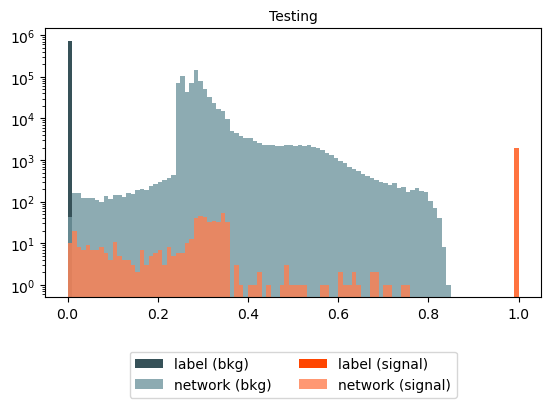

<Figure size 640x480 with 0 Axes>

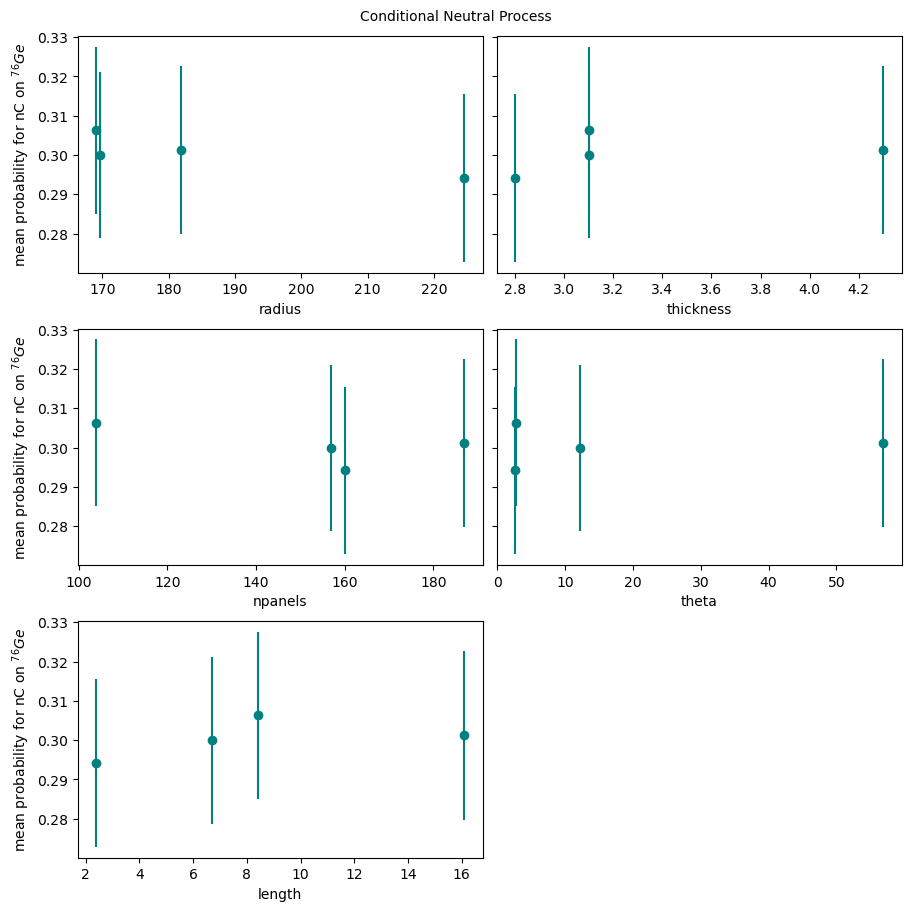

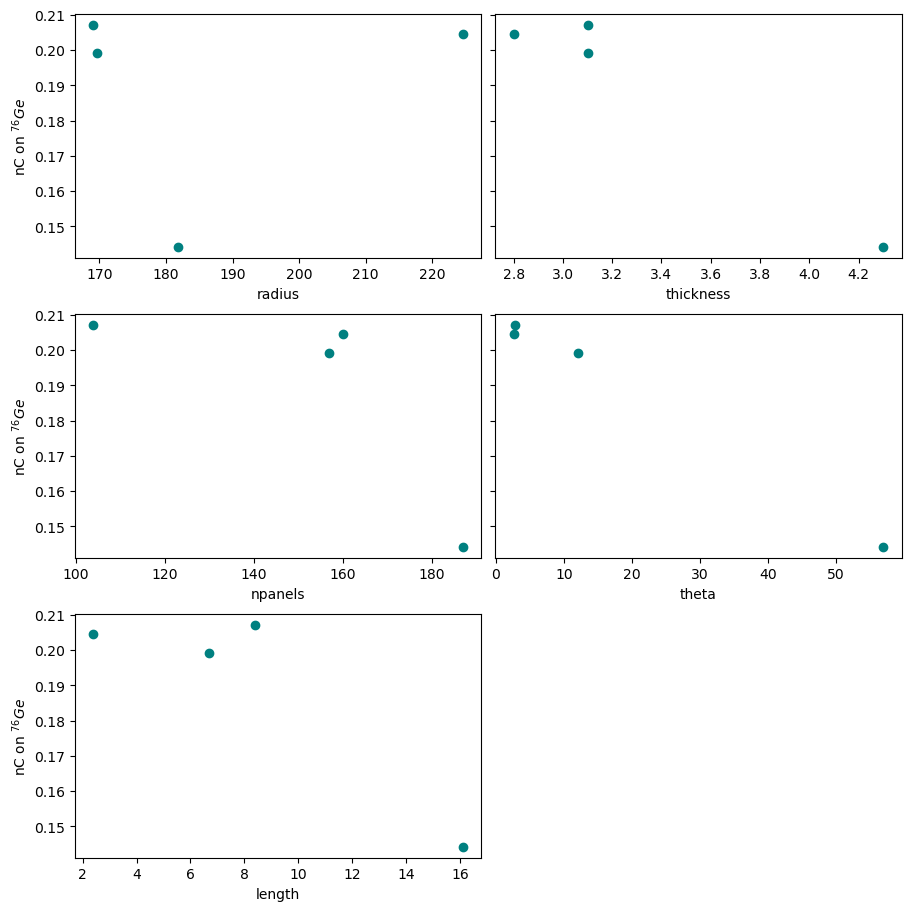

In [11]:

version_hf="n1.5"
mode="HF"
filelist = utils.get_all_files(f"../simulation/out/{mode}/{version_hf}/tier2/neutron-sim-HF-n{version_hf[1:]}")

x_hf = np.empty([0,6])
sum_target_y_hf = np.empty([0,1])
mean_mu_cnp_hf = np.empty([0,1])
mean_sigma_cnp_hf = np.empty([0,1])
upper_lim_hf = np.empty([0,1])
hist_target_sig = hist_target_bkg = hist_pred_sig = hist_pred_bkg = np.zeros(100)
fout = open(f'{path_out}{f_out}_training_new_samples.txt', "a")
rGe77_hf = np.empty([0,1])
# create a PdfPages object
pdf=PdfPages(f'{path_out}{f_out}_result_{mode}_new_samples.pdf')

for i,file in enumerate(filelist):

    path_to_files = file[:-4]
    num_total_points = 0
    with open(file, "rbU") as f:
        num_total_points += int(np.floor(sum(1 for _ in f)))

    MAX_CONTEXT_POINTS_NEW = int(1/3 * (num_total_points-1))
    MAX_TARGET_POINTS_NEW = 2 * MAX_CONTEXT_POINTS_NEW

    dataset_config = data.DataGeneration(num_iterations=1, num_context_points=MAX_CONTEXT_POINTS_NEW, num_target_points=MAX_TARGET_POINTS_NEW, batch_size = 1, use_data_augmentation="None", path_to_files=path_to_files,x_size=x_size,y_size=y_size, mode = "config", ratio_testing=0.,names_x=names_x, name_y=name_y)
    data_config = dataset_config.get_data(0, CONTEXT_IS_SUBSET)
    
    # Get the predicted mean and variance at the target points for the testing set
    log_prob_config, mu_config, sigma_config = model(data_config.query, data_config.target_y)
    # Define the loss
    config_loss = -log_prob_config.mean()
    if max(mu_config[0].detach().numpy()) <= 1 and min(mu_config[0].detach().numpy()) >= 0:
            loss_bce_config = bce(mu_config,  data_config.target_y)
    else:
            loss_bce_config = -1.

    mu_config = mu_config[0].detach().numpy()
    
    target_y = data_config.target_y[0].detach().numpy()
    df = pd.read_csv(file, index_col=0)
    x_hf         = np.append(x_hf,[df[["fidelity","radius","thickness","npanels","theta","length"]].to_numpy()[0]],axis=0)
    #x         = np.append(x,[data_config.query[1][0][0][-5:].numpy()],axis=0)
    sum_target_y_tmp = np.array([np.sum(target_y)])
    sum_target_y_hf    = np.append(sum_target_y_hf, [sum_target_y_tmp], axis=0)
    mean_mu_tmp = np.array([np.mean(mu_config)])
    upper_lim_hf = np.append(upper_lim_hf,[np.array([np.percentile(mu_config,95.)])], axis=0)
    mean_mu_cnp_hf = np.append(mean_mu_cnp_hf, [mean_mu_tmp], axis=0)
    mean_sigma_tmp = np.array([np.mean(sigma_config[0].detach().numpy())])
    mean_sigma_cnp_hf = np.append(mean_sigma_cnp_hf, [mean_sigma_tmp], axis=0)
    rGe77_hf = np.append(rGe77_hf,[np.array([np.sum(pd.read_csv(file)["prod_rate_Ge77[nuc/(kg*yr)]"].to_numpy())])], axis=0)
    
    hist_target_sig, hist_target_bkg, hist_pred_sig, hist_pred_bkg = plotting.sum_hist(mu_config, target_y, hist_target_sig, hist_target_bkg, hist_pred_sig, hist_pred_bkg)
    print("{}/{} {}, {}, radius: {} cm, test loss: {} (bce {})".format(i,len(filelist),datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), mode,x_hf[-1,1], config_loss, loss_bce_config))
    fout.write("{}, Iteration: {}, test loss: {} (bce {})\n".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i, config_loss, loss_bce_config))
    
    fig = plotting.plot_result_configwise(mu_config, target_y, f'{config_loss:.2f}', x_hf[-1])
    plt.close(fig)
    pdf.savefig(fig)
    #plt.show()
    plt.clf()

    
fig1 = plotting.plot_result_summed(hist_target_sig, hist_target_bkg, hist_pred_sig, hist_pred_bkg)
pdf.savefig(fig1)
plt.show()
plt.clf()

fig2,_ = plt.subplots(3,2,sharey=True,figsize=(9, 9),layout="constrained")
ax2 = fig2.axes
for i in range(len(x_hf[0,:])-1):
    #ax2[i].plot(x_lf[:,0],mean_mu_cnp,'o')
    ax2[i].errorbar(x_hf[:,i+1], mean_mu_cnp_hf[:,0], yerr=mean_sigma_cnp_hf[:,0],fmt='o', color='teal')
    
    ax2[i].set_xlabel(names_x[i])
    if i % 2 == 0:
        ax2[i].set_ylabel(r'mean probability for nC on $^{76}Ge$')
for i in range(len(x_hf[0,:])-1,len(ax2)):
     ax2[i].set_axis_off()
fig2.suptitle('Conditional Neutral Process', fontsize=10)
pdf.savefig(fig2)
plt.show()

fig3,_ = plt.subplots(3,2,sharey=True,figsize=(9, 9),layout="constrained")
ax3 = fig3.axes
for i in range(len(x_hf[0,:])-1):
    ax3[i].plot(x_hf[:,i+1],rGe77_hf,'o', color='teal')
    if i % 2 == 0:
        ax3[i].set_ylabel(r'nC on $^{76}Ge$')
    ax3[i].set_xlabel(names_x[i])
for i in range(len(x_hf[0,:])-1,len(ax3)):
     ax3[i].set_axis_off()
pdf.savefig(fig3)
plt.show()

pdf.close()
fout.close()

df= pd.read_csv(f'{path_out}{f_out}_Ge77rates_new_samples.csv', index_col=0)
samples=np.arange(len(df))
x = df[["Mode","Radius[cm]","Thickness[cm]","NPanels","Theta[deg]","Length[cm]","Ge-77[nevents]","Ge-77_CNP","Ge-77_CNP_err","rGe77[nuc/(kg*yr)]"]].to_numpy()
x_tmp = np.append(x_hf, sum_target_y_hf, axis=1)
x_tmp = np.append(x_tmp, mean_mu_cnp_hf, axis=1)
x_tmp = np.append(x_tmp, mean_sigma_cnp_hf, axis=1)
x_tmp = np.append(x_tmp, rGe77_hf, axis=1)
x = np.append(x, x_tmp, axis=0)
df = pd.DataFrame(x, columns=df.columns)
samples = np.append(samples,[np.arange(len(x_hf))])

df=df.round(decimals=4)
df.to_csv(f'{path_out}{f_out}_Ge77rates_new_samples.csv')
df.insert(0,"Sample",samples)
df.to_csv(f'../multi-fidelity-gaussian-process/in/Ge77_rates_new_samples_{version}.csv')



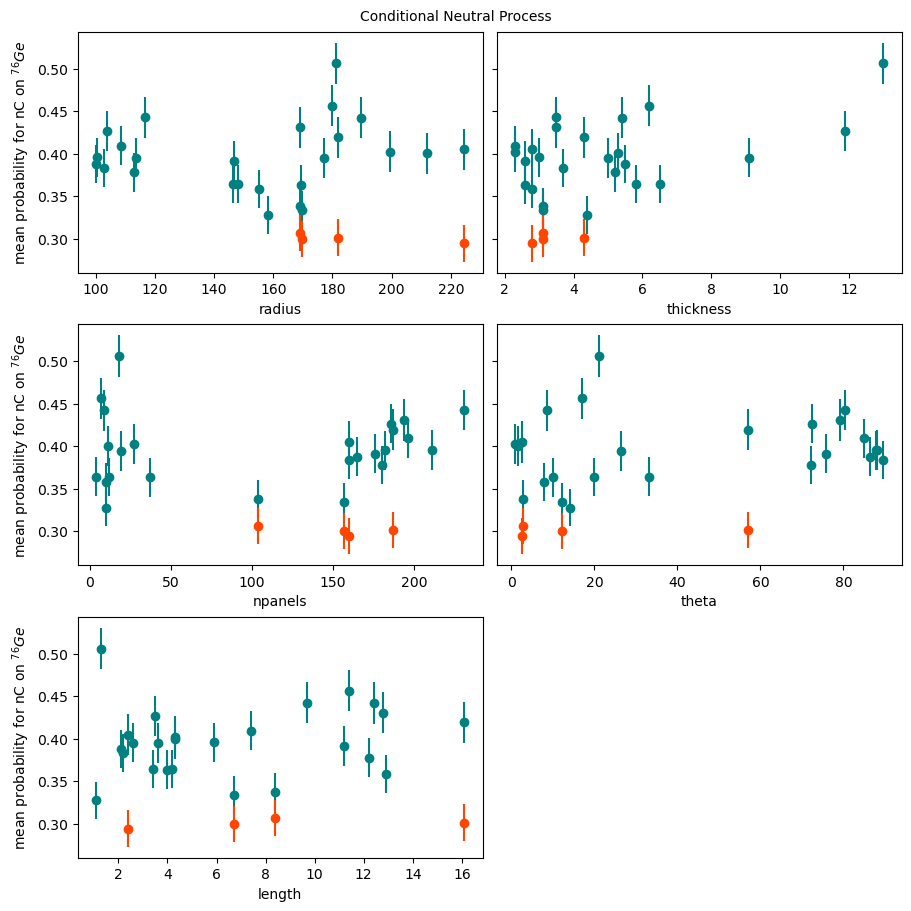

In [12]:
fig4,_ = plt.subplots(3,2,sharey=True,figsize=(9, 9),layout="constrained")
fig4.suptitle('Conditional Neutral Process', fontsize=10)
ax4 = fig4.axes

for i in range(len(x_lf[0,:])-1):
    ax4[i].errorbar(x_lf[:,i+1], mean_mu_cnp_lf[:,0], yerr=mean_sigma_cnp_lf[:,0],fmt='o', color='teal')
    ax4[i].set_xlabel(names_x[i])
    if i % 2 == 0:
        ax4[i].set_ylabel(r'mean probability for nC on $^{76}Ge$')

for i in range(len(x_hf[0,:])-1):
    #ax2[i].plot(x_lf[:,0],mean_mu_cnp,'o')
    ax4[i].errorbar(x_hf[:,i+1], mean_mu_cnp_hf[:,0], yerr=mean_sigma_cnp_hf[:,0],fmt='o', color='orangered')
    ax4[i].set_xlabel(names_x[i])

for i in range(len(x_lf[0,:])-1,len(ax4)):
     ax4[i].set_axis_off()



for i in range(len(x_hf[0,:])-1,len(ax4)):
     ax4[i].set_axis_off()

#pdf.savefig(fig4)
plt.show()